# Chuẩn bị dữ liệu

In [ ]:
!gdown 1hAHZI1vLdTBnye-6XTdPBvky8f4HwidL

Downloading...
From: https://drive.google.com/uc?id=1hAHZI1vLdTBnye-6XTdPBvky8f4HwidL
To: /content/IMDB Dataset.csv.zip
100% 27.0M/27.0M [00:00<00:00, 77.2MB/s]


In [ ]:
!unzip "./IMDB Dataset.csv.zip"

Archive:  ./IMDB Dataset.csv.zip
  inflating: IMDB Dataset.csv        


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('./IMDB Dataset.csv')

In [ ]:
data.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [ ]:
le = LabelEncoder()

In [ ]:
data['sentiment_target'] = le.fit_transform(data.sentiment)

In [ ]:
data.head()

,review,sentiment,seintiment_target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
keras_token = Tokenizer(num_words=10000)
keras_token.fit_on_texts(data.review)

In [ ]:
keras_result = keras_token.texts_to_sequences(data.review)

In [ ]:
keras_pad_result = tf.keras.preprocessing.sequence.pad_sequences(keras_result, maxlen=400, padding='post')

In [ ]:
keras_pad_result.shape

(50000, 400)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(keras_pad_result, 
                                                    data['sentiment_target'].values, 
                                                    test_size=0.5, 
                                                    random_state=42, 
                                                    stratify=data['sentiment_target'].values)

In [ ]:
y_train = np.reshape(y_train, (-1,1))

In [ ]:
y_test = np.reshape(y_test, (-1,1))

In [ ]:
x_train.shape

(25000, 400)

In [ ]:
y_train.shape

(25000, 1)

# Tạo và train model

In [ ]:
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Input, Activation, Lambda, Concatenate
from tensorflow.keras.layers import Embedding, Conv1D, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K

In [ ]:
batch_size = 32
embedding_dims = 200
n_filter = 150
hidden_dims = 100
max_features = 10000
maxlen = 400

In [ ]:
 model = Sequential()
 input_layer = Input(shape=(maxlen),dtype='int32', name='main_input')
 emb_layer = Embedding(max_features,
                          embedding_dims,
                          input_length=maxlen
                          )(input_layer)
def max_1d(X):
        return K.max(X, axis=1)
con3_layer = Conv1D(n_filter,
                        3,
                        padding='valid',
                        activation='relu',
                    strides=1)(emb_layer)
pool_con3_layer = Lambda(max_1d, output_shape=(n_filter,))(con3_layer)
con4_layer = Conv1D(n_filter,
                        5,
                        padding='valid',
                        activation='relu',
                        strides=1)(emb_layer)
pool_con4_layer = Lambda(max_1d, output_shape=(n_filter,))(con4_layer)
con5_layer = Conv1D(n_filter,
                        7,
                        padding='valid',
                        activation='relu',
                        strides=1)(emb_layer)
pool_con5_layer = Lambda(max_1d, output_shape=(n_filter,))(con5_layer)
cnn_layer = Concatenate()([pool_con3_layer, pool_con5_layer,pool_con4_layer ])

emb2_layer = Embedding(max_features, embedding_dims, input_length=maxlen)(input_layer)
lstm_layer = LSTM(128)(emb2_layer)
cnn_lstm_layer = Concatenate()([lstm_layer, cnn_layer])
dense_layer = Dense(hidden_dims*2, activation='sigmoid')(cnn_lstm_layer)
output_layer= Dropout(0.2)(dense_layer)
output_layer = Dense(1, trainable=True,activation='sigmoid')(output_layer)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 400)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 400, 200)     2000000     ['main_input[0][0]']             
                                                                                                  
 conv1d (Conv1D)                (None, 398, 150)     90150       ['embedding[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)              (None, 394, 150)     210150      ['embedding[0][0]']              
                                                                                              

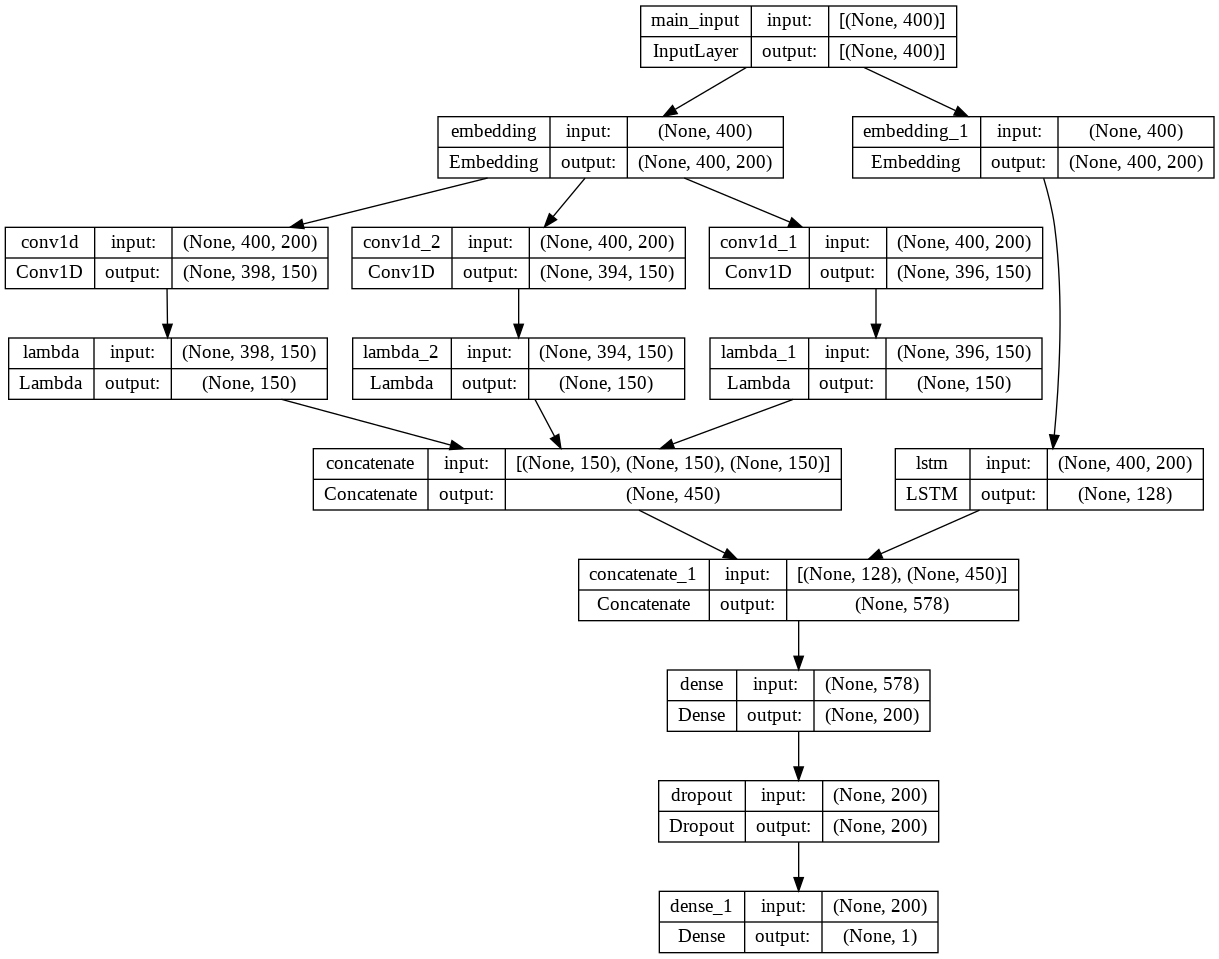

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer="adamax",
                  metrics=['accuracy'])

In [ ]:
training_info = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=batch_size)

Epoch 1/3
782/782 [==============================] - 47s 47ms/step - loss: 0.4974 - accuracy: 0.7364 - val_loss: 0.3469 - val_accuracy: 0.8477
Epoch 2/3
782/782 [==============================] - 37s 47ms/step - loss: 0.2680 - accuracy: 0.8898 - val_loss: 0.2806 - val_accuracy: 0.8827
Epoch 3/3
782/782 [==============================] - 36s 46ms/step - loss: 0.1803 - accuracy: 0.9320 - val_loss: 0.2388 - val_accuracy: 0.9024


# Vẽ biểu đồ và dự đoán

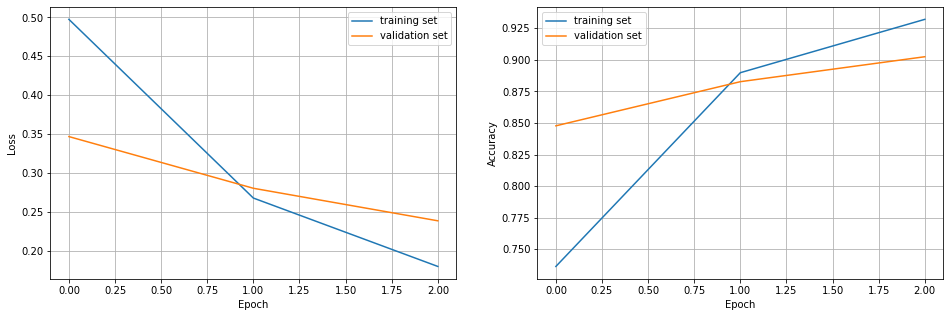

In [ ]:
def plot_training_history(training_info):
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set")
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['accuracy'], label="training set")
    axs[1].plot(training_info.history['val_accuracy'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info)

In [ ]:
thresholds = np.arange(0,1.01,0.01)

In [ ]:
def calc_thr(x, thr):
  a = np.copy(x)
  for i in range(len(a)):
    if a[i] > thr:
      a[i] = 1
    else: a[i] = 0
  return a

In [ ]:
from sklearn.metrics import confusion_matrix
import scipy.interpolate, scipy.optimize

In [ ]:
y_pre = model.predict(x_test)

782/782 [==============================] - 10s 12ms/step


In [ ]:
far = []
frr = []
for i in range(len(thresholds)):
  y_prediction = calc_thr(y_pre, thresholds[i])
  result = confusion_matrix(y_test, y_prediction , normalize='all')
  far.append(result[0][1])
  frr.append(result[1][0])
interp1 = scipy.interpolate.InterpolatedUnivariateSpline(thresholds, far)
interp2 = scipy.interpolate.InterpolatedUnivariateSpline(thresholds, frr)
def difference(x):
    return np.abs(interp1(x) - interp2(x))
best_threshold = scipy.optimize.fsolve(difference, x0=3.0)

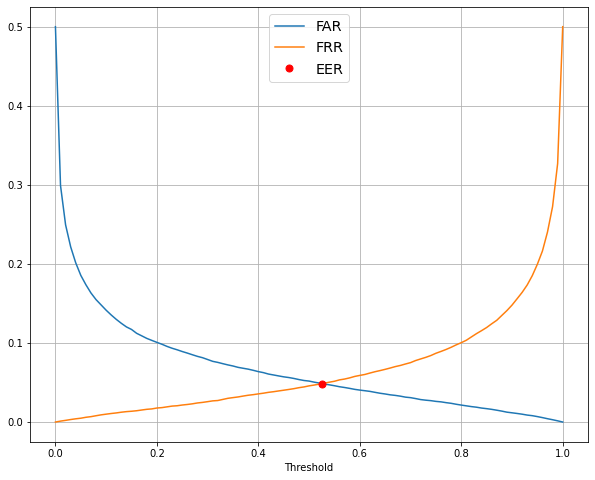

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.grid(True)
ax.plot(thresholds, far,  label='FAR')
ax.plot(thresholds, frr,  label='FRR')
ax.plot(best_threshold, interp1(best_threshold),'ro', ms=7, label='EER')
plt.xlabel('Threshold')
legend = ax.legend( fontsize='x-large')
legend.get_frame()
plt.show()

In [ ]:
# Sample url: https://www.imdb.com/title/tt9114286/reviews
sample = ["Bad editing ruined it; the stellar score and wardrobe couldn't save it.",
          "Extremely Emotional Movie About Loss, Legacy And Healing!",
          "The Beautifully Crafted Film Is Heart Wrenching, But Showcases The Power Of Identity, Culture, Family And Pride",
          "Enough has been said by other reviewers about the film's overall weaknesses - it's overlong, meandering and drags in many places. Instead, I want to focus on a question no one else seems to be asking: what is up with these Wakandans?",
          "Terrible",
          "wonderful"]
sample_result = keras_token.texts_to_sequences(sample)
sample_pad_result = tf.keras.preprocessing.sequence.pad_sequences(sample_result, maxlen=400, padding='post')
result = model.predict(sample_pad_result)
for i in range(len(sample)):
  if result[i][0] >= best_threshold:
    print("Positive:", result[i][0], '->', sample[i])
  else:
    print("Negative:", result[i][0], '->', sample[i])

1/1 [==============================] - 0s 77ms/step
Negative: 0.003836673 -> Bad editing ruined it; the stellar score and wardrobe couldn't save it.
Positive: 0.92037106 -> Extremely Emotional Movie About Loss, Legacy And Healing!
Positive: 0.9997955 -> The Beautifully Crafted Film Is Heart Wrenching, But Showcases The Power Of Identity, Culture, Family And Pride
Negative: 0.027608482 -> Enough has been said by other reviewers about the film's overall weaknesses - it's overlong, meandering and drags in many places. Instead, I want to focus on a question no one else seems to be asking: what is up with these Wakandans?
Negative: 0.07244555 -> Terrible
Positive: 0.9405541 -> wonderful


---